#Assignment 4

### Name : Parth Thakkar,  Roll : CS22MTECH14005

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from math import exp
import sklearn

## Generating The dataset

In [ ]:
min = 2 #Min sequence length
max = 9 #Max sequence length
N = 5000 #Dataset size

In [ ]:
data_list = [] #Features
output = []    #ouput

In [ ]:
random.seed(1)
np.random.seed(1)
for i in range(N):
  #Generate features having values from 0 to 1, of dimension [2,9](any value from 2 to 9) X 2
  X = np.random.uniform(0.0,1.0,size  = (random.randint(2,9),2))
  X = torch.tensor(X , dtype = torch.float32)
  X[:,1] = 0

  #Assigning 1 to 2nd dimension of any 2 features of the particular sequence
  y1  = random.sample(range(0,X.shape[0]), 2)
  X[y1[0]][1] = 1
  X[y1[1]][1] = 1

  #Appending the features and output to the respective lists
  data_list.append(X)
  output.append(X[y1[0]][0]+X[y1[1]][0])

In [ ]:
#Printing example of the data set generated and its output
print("data :")
print(data_list[1])
print("Corresponding output :",output[1])

data :
tensor([[0.3968, 0.0000],
        [0.4192, 1.0000],
        [0.2045, 1.0000]])
Corresponding output : tensor(0.6236)


In [ ]:
#Splitting the data into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_list, output, test_size=0.2, random_state=42)

## Elman

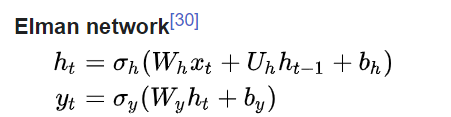

In [ ]:
#Creating an Elman class according to the above equation
class Elman(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(Elman,self).__init__()

    self.hidden_size = hidden_size
    self.l2h = nn.Linear(input_size+hidden_size,hidden_size)
    self.tanh = nn.Tanh()
    self.l2o = nn.Linear(hidden_size,1)


  def forward(self,input,hidden):
    combined = torch.cat((input,hidden),dim = 0)
    hidden = self.tanh(self.l2h(combined))
    output = self.l2o(hidden)

    return hidden,output

  def init_helper(self):
    return torch.zeros(self.hidden_size)

In [ ]:
#Creating object of Elman class
torch.manual_seed(88)
model = Elman(2,4,1)

In [ ]:
#Defining loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)

In [ ]:
#List that will keep track of losses in Elman
losses_RNN = []

In [ ]:
#Epochs
epochs = 20

In [ ]:
#Training loop
for ep in range(epochs):
  #Keeping track of loss at each epoch
  ep_loss = 0
  for i in range(len(X_train)):

    #initializing hidden state
    hidden = model.init_helper()

    #variable to store the final output
    y_pred = 0

    #forward pass for each sequence
    for seq in X_train[i]:
      hidden,y_pred = model(seq,hidden)

    #Calculating loss
    loss = criterion(y_pred[0],y_train[i])
    ep_loss += loss

    #Backward propogation and parameter updation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    hidden = hidden.detach()

  #Appending avg loss per epoch to the list
  losses_RNN.append((ep_loss/len(X_train)).detach())
  if(ep%2 == 0):
    print(f"Avg loss at epoch {ep} : {(ep_loss/len(X_train)).detach()}")

Avg loss at epoch 0 : 0.1078256145119667
Avg loss at epoch 2 : 0.012801002711057663
Avg loss at epoch 4 : 0.012105542235076427
Avg loss at epoch 6 : 0.011742204427719116
Avg loss at epoch 8 : 0.011392001993954182
Avg loss at epoch 10 : 0.010864119976758957
Avg loss at epoch 12 : 0.010587718337774277
Avg loss at epoch 14 : 0.01041902881115675
Avg loss at epoch 16 : 0.010395144112408161
Avg loss at epoch 18 : 0.010420803911983967


In [ ]:
#testing the model on test data
y_pred = []
for i in range(len(X_test)):
    output = 0
    hidden = model.init_helper()
    for se in X_test[i]:
        hidden,output = model(se,hidden)
    y_pred.append(output)

### Accuracy of Elman on test data while allowing absolute difference of 0.02

In [ ]:
n = 0
for i in range(len(y_test)):
    if(abs(y_pred[i]-y_test[i])<=0.02):
        n += 1
Accuracy_RNN = round((n/len(y_test))*100,3)

In [ ]:
print(f"Accuracy of Elman is {Accuracy_RNN} %")

Accuracy of Elman is 27.4 %


## LSTM

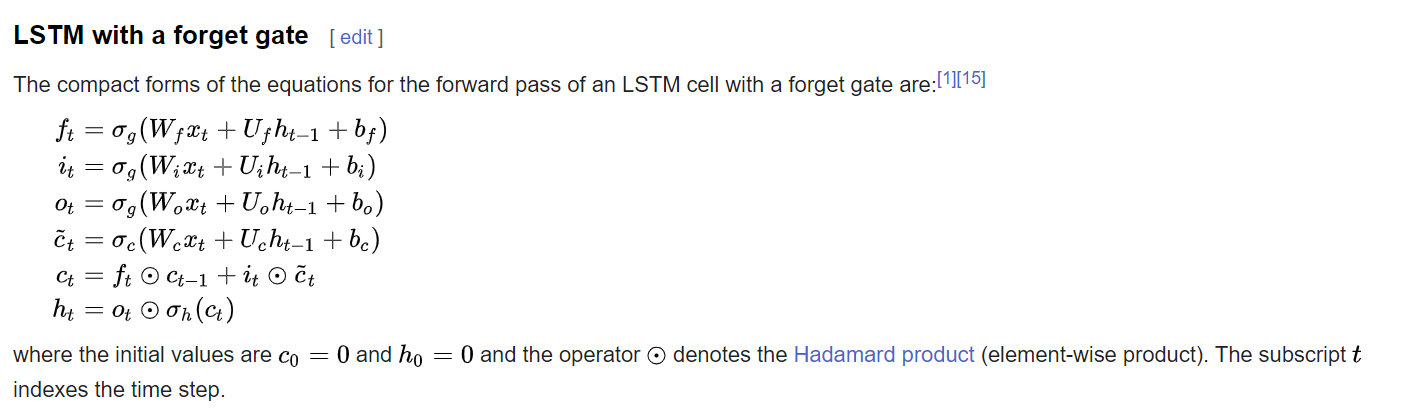

In [ ]:
#Creating an LSTM class according to the above equation
class LSTM(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(LSTM,self).__init__()

    self.hidden_size = hidden_size
    self.ft = nn.Linear(input_size+hidden_size,hidden_size)
    self.it = nn.Linear(input_size+hidden_size,hidden_size)
    self.ot = nn.Linear(input_size+hidden_size,hidden_size)
    self.c_ = nn.Linear(input_size+hidden_size,hidden_size)
    self.sig = nn.Sigmoid()
    self.tanh = nn.Tanh()
    self.out = nn.Linear(hidden_size,1)


  def forward(self,input,hidden,c_t):
    combined = torch.cat((input,hidden),dim = 0)
    f_t = self.sig(self.ft(combined))
    i_t = self.sig(self.it(combined))
    o_t = self.sig(self.ot(combined))
    c_ = self.tanh(self.c_(combined))
    c_t = f_t * c_t + i_t * c_
    hidden = o_t * self.tanh(c_t)
    output = self.out(hidden)
    return c_t,hidden,output

  def init_helper(self):
    return torch.zeros(self.hidden_size),torch.zeros(self.hidden_size)

In [ ]:
#Creating an object of LSTM class with hidden size 16
torch.manual_seed(88)
Lstm = LSTM(2,16,1)

In [ ]:
#Defining loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Lstm.parameters(),lr = 0.01)

In [ ]:
#Defining a list
losses_LSTM = []

In [ ]:
#Epochs
epochs = 20

In [ ]:
#Training loop
for ep in range(epochs):

  #Keeping track of loss at each epoch
  ep_loss = 0
  for i in range(len(X_train)):

    #Inintializing cell state and hidden state
    hidden,c_t = Lstm.init_helper()

    #variable to store the final output of the lstm
    y_pred = 0

    #forward pass for each sequence
    for seq in X_train[i]:
      c_t,hidden,y_pred = Lstm(seq,hidden,c_t)

    #Calculating loss
    loss = criterion(y_pred[0],y_train[i])

    #Backward prop and parameter updatation
    ep_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    hidden = hidden.detach()
    c_t = c_t.detach()

  #Appending avg loss per epoch to the list
  losses_LSTM.append((ep_loss/len(X_train)).detach())
  if(ep%2 == 0):
    print(f"Avg loss at epoch {ep} : {(ep_loss/len(X_train)).detach()}")

Avg loss at epoch 0 : 0.035417340695858
Avg loss at epoch 2 : 0.0015367604792118073
Avg loss at epoch 4 : 0.0006325269350782037
Avg loss at epoch 6 : 0.00041199399856850505
Avg loss at epoch 8 : 0.00031238229712471366
Avg loss at epoch 10 : 0.0002500592381693423
Avg loss at epoch 12 : 0.00022299283591564745
Avg loss at epoch 14 : 0.0002012238255701959
Avg loss at epoch 16 : 0.00018208801338914782
Avg loss at epoch 18 : 0.00017015350749716163


In [ ]:
#testing the model on test data
y_pred = []
for i in range(len(X_test)):
    output = 0
    hidden,c_t = Lstm.init_helper()
    for se in X_test[i]:
        c_t,hidden,output = Lstm(se,hidden,c_t)
    y_pred.append(output)

### Accuracy of LSTM on test data while allowing absolute difference of 0.02

In [ ]:
n = 0
for i in range(len(y_test)):
    if(abs(y_pred[i]-y_test[i])<=0.02):
        n += 1
Accuracy_LSTM = round((n/len(y_test))*100,3)

In [ ]:
print(f"Accuracy of LSTM is {Accuracy_LSTM} %")

Accuracy of LSTM is 93.9 %


## GRU

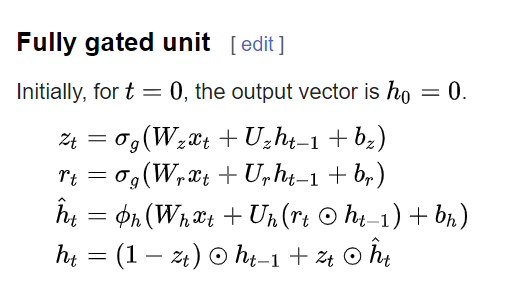

In [ ]:
#Creating an GRU class according to the above equation
class GRU(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(GRU,self).__init__()

    self.hidden_size = hidden_size
    self.zt = nn.Linear(input_size+hidden_size,hidden_size)
    self.rt = nn.Linear(input_size+hidden_size,hidden_size)
    self.h_ = nn.Linear(input_size+hidden_size,hidden_size)
    self.sig = nn.Sigmoid()
    self.tanh = nn.Tanh()
    self.out = nn.Linear(hidden_size,1)


  def forward(self,input,hidden):
    combined = torch.cat((input,hidden),dim = 0)
    z_t = self.sig(self.zt(combined))
    r_t = self.sig(self.rt(combined))
    temp = r_t * hidden
    combined = torch.cat((input,temp),dim = 0)
    ht_ = self.tanh(self.h_(combined))
    ht = (1-z_t) * hidden + z_t * ht_
    out = self.out(ht)
    return ht,out

  def init_helper(self):
    return torch.zeros(self.hidden_size)

In [ ]:
#Generating a gru model object with hidden size 16
torch.manual_seed(88)
gru = GRU(2,16,1)

In [ ]:
#Defining loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru.parameters(),lr = 0.01)

In [ ]:
#generating a list to keep track of loesses at each epoch
losses_GRU = []

In [ ]:
#Epochs
epochs = 20

In [ ]:
#Training loop
for ep in range(epochs):

  #Variable to keep track of avg loss at each epoch
  ep_loss = 0
  for i in range(len(X_train)):

    #initializing hidden state
    hidden = gru.init_helper()

    #variable to store the final output of GRU
    y_pred = 0

    #forward pass for each sequence
    for seq in X_train[i]:
      hidden,y_pred = gru(seq,hidden)

    #Calculating loss
    loss = criterion(y_pred[0],y_train[i])
    ep_loss += loss

    #backward prop and parameter updation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    hidden = hidden.detach()

  #Appending avg loss per epoch to the list
  losses_GRU.append((ep_loss/len(X_train)).detach())
  if(ep%2 == 0):
    print(f"Avg loss at epoch {ep} : {(ep_loss/len(X_train)).detach()}")

Avg loss at epoch 0 : 0.016592931002378464
Avg loss at epoch 2 : 0.0009872674709185958
Avg loss at epoch 4 : 0.0008053770288825035
Avg loss at epoch 6 : 0.0004920096835121512
Avg loss at epoch 8 : 0.00033528413041494787
Avg loss at epoch 10 : 0.00029159546829760075
Avg loss at epoch 12 : 0.0002538285916671157
Avg loss at epoch 14 : 0.00022937703761272132
Avg loss at epoch 16 : 0.00022842077305540442
Avg loss at epoch 18 : 0.00020918232621625066


In [ ]:
#testing our GRU model on test data
y_pred = []
for i in range(len(X_test)):
    output = 0
    hidden = gru.init_helper()
    for se in X_test[i]:
        hidden,output = gru(se,hidden)
    y_pred.append(output)

### Accuracy of GRU on test data while allowing absolute difference of 0.02

In [ ]:
n = 0
for i in range(len(y_test)):
    if(abs(y_pred[i]-y_test[i])<=0.02):
        n += 1
Accuracy_GRU = round((n/len(y_test))*100,3)

In [ ]:
print(f"Accuracy of GRU is {Accuracy_GRU} %")

Accuracy of GRU is 99.9 %


## Baseline Calculation

In [ ]:
#Calculating baseline performance s.t. model predicts sum of 1 regardless of the input sequence
losses_baseline = []
loss = 0
for i in range(len(X_train)):
    loss += criterion(torch.tensor(1),y_train[i])

In [ ]:
losses_baseline.extend([loss/len(X_train)] * 20)

##The final comparision

### Accuracies

In [ ]:
print(f"Accuracy of Elman is {Accuracy_RNN} %")
print(f"Accuracy of LSTM is  {Accuracy_LSTM} %")
print(f"Accuracy of GRU is   {Accuracy_GRU} %")

Accuracy of Elman is 27.4 %
Accuracy of LSTM is  93.9 %
Accuracy of GRU is   99.9 %


### Plotting the Loss graphs of all the models

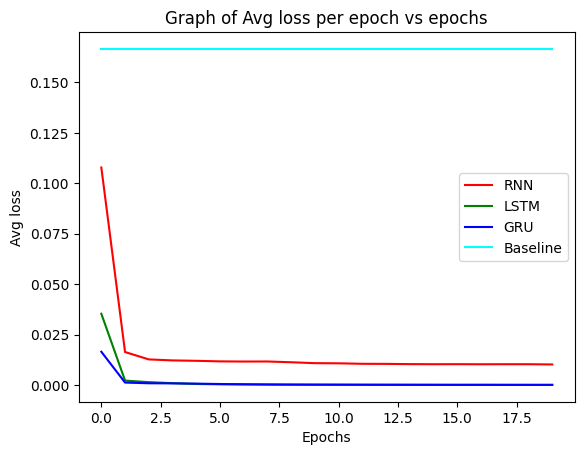

In [ ]:
plt.plot(np.arange(0,len(losses_RNN)),losses_RNN,color = 'red',label = "RNN")
plt.plot(np.arange(0,len(losses_LSTM)),losses_LSTM,color = 'green',label = "LSTM")
plt.plot(np.arange(0,len(losses_GRU)),losses_GRU,color = 'blue',label = "GRU")
plt.plot(np.arange(0,len(losses_baseline)),losses_baseline,color = 'cyan',label = "Baseline")
plt.xlabel("Epochs")
plt.ylabel("Avg loss")
plt.title("Graph of Avg loss per epoch vs epochs")
plt.legend()
plt.show()